In [51]:
import jax
import jraph
import data
import metadata
import optax
import utils

import haiku as hk
import typing as t
import jax.numpy as jnp

In [2]:
BLOCK_SIZE = int(24*60/5)
BATCH_SIZE = 8
SPLIT = 0.85
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
SEED = 2137
NUM_TRAINING_STEPS = 300
EVAL_INTERVAL = 10
EMBEDDING_SIZE = 1

In [3]:
def get_graph(_edges: jnp.array) -> jraph.GraphsTuple:
    graph = jraph.GraphsTuple(
        edges=_edges,
        senders=jnp.array(sdl.senders, dtype=jnp.int32),
        receivers=jnp.array(sdl.receivers, dtype=jnp.int32),
        n_node=metadata.NUM_NODES,
        n_edge=metadata.NUM_EDGES,
        nodes=jnp.array([[1] * metadata.NUM_NODES]),
        globals=None
    )
    return graph

In [4]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.pkl", BLOCK_SIZE, BATCH_SIZE, EMBEDDING_SIZE, SPLIT)
train_di = sdl.get_graph_data_iter("train")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
expl_edge_data = next(train_di)  # {str: (B, E, T)}
expl_graph = get_graph(expl_edge_data['input'][0])

expl_graph.n_node, expl_graph.n_edge, expl_graph.edges.shape

(6, 15, (15, 288))

In [71]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class StatefulField(t.NamedTuple):
    embedding: t.Any
    state: t.Any

@jax.jit
def embed(arr: jnp.array) -> jnp.array:
    arr = jnp.log(arr + 1)
    return arr[:, :, None]

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:

    edge_fn_gru = hk.GRU(HIDDEN_SIZE)
    batch_size = graph.edges.shape[0]
    initial_state = edge_fn_gru.initial_state(batch_size)

    graph = graph._replace(
        edges=StatefulField(
            embedding=embed(graph.edges),
            state=initial_state),
    )

    # custom GraphMapFeatures that transfers RNN state
    def update_edge_fn(edges: StatefulField) -> StatefulField:
        # edges -> (E, T, F)
        logits, updated_state = hk.dynamic_unroll(
            edge_fn_gru, edges.embedding, edges.state, time_major=False)  # (E, T, HIDDEN)
        logits = hk.BatchApply(hk.Linear(EMBEDDING_SIZE))(logits)  # (E, T, F)

        updated_edges = StatefulField(embedding=logits, state=updated_state)
        return updated_edges

    def update_node_fn(nodes):
        return nodes

    net = jraph.GraphMapFeatures(
        embed_edge_fn=update_edge_fn,
        embed_node_fn=update_node_fn,
    )

    return net(graph)

@jax.jit
def update(state: TrainingState, edge_data: t.Dict) -> t.Tuple[TrainingState, jnp.array]:
    _, optimizer = make_optimizer()
    _graph = get_graph(edge_data['input'][0])
    _target = edge_data['target'][0]
    _loss, gradients = jax.value_and_grad(loss)(state.params, _graph, _target, net_apply)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state), _loss


def loss(params: hk.Params, graph: jraph.GraphsTuple,
         target: jnp.array, net_apply: t.Any) -> jnp.array:
    gr = net_apply(params, graph)
    logits = gr.edges.embedding  # (E, T, F)
    return jnp.mean(jnp.abs(embed(target) - logits))  # MAE

In [75]:
rng = jax.random.PRNGKey(SEED)

net_init, net_apply = hk.without_apply_rng(hk.transform(net_fn))
initial_params = net_init(rng, expl_graph)

opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

state = TrainingState(params=initial_params, opt_state=initial_opt_state)

for step in range(NUM_TRAINING_STEPS):
    train_batch = next(train_di)
    state, train_loss = update(state, train_batch)

    if step % EVAL_INTERVAL == 0:
        print(f"Step: {step} | train loss: {float(train_loss):.3f} | vali loss: {0.0:.3f}")

final_state = state

Step: 0 | train loss: 12.407 | vali loss: 0.000
Step: 10 | train loss: 9.420 | vali loss: 0.000
Step: 20 | train loss: 7.131 | vali loss: 0.000
Step: 30 | train loss: 5.368 | vali loss: 0.000
Step: 40 | train loss: 4.127 | vali loss: 0.000
Step: 50 | train loss: 3.272 | vali loss: 0.000
Step: 60 | train loss: 2.350 | vali loss: 0.000
Step: 70 | train loss: 1.456 | vali loss: 0.000
Step: 80 | train loss: 0.796 | vali loss: 0.000
Step: 90 | train loss: 0.413 | vali loss: 0.000
Step: 100 | train loss: 0.314 | vali loss: 0.000
Step: 110 | train loss: 0.273 | vali loss: 0.000
Step: 120 | train loss: 0.251 | vali loss: 0.000
Step: 130 | train loss: 0.241 | vali loss: 0.000
Step: 140 | train loss: 0.238 | vali loss: 0.000
Step: 150 | train loss: 0.231 | vali loss: 0.000
Step: 160 | train loss: 0.227 | vali loss: 0.000
Step: 170 | train loss: 0.225 | vali loss: 0.000
Step: 180 | train loss: 0.221 | vali loss: 0.000
Step: 190 | train loss: 0.220 | vali loss: 0.000
Step: 200 | train loss: 0.216 

In [81]:
class LoopValues(t.NamedTuple):
    graph: jraph.GraphsTuple
    state: t.Any

In [198]:
def generate(graph: jraph.GraphsTuple, seq_len: int) -> jnp.array:
    sequence_length = graph.edges.shape[1]

    gr = net_apply(final_state.params, graph)
    context_outs = gr.edges.embedding[:, :, -1]  # (E, T)
    res = gr.edges.embedding[:, :, -1]  # (E, T)

    output_seq = jnp.zeros((metadata.NUM_EDGES, seq_len - sequence_length))
    for t in range(seq_len - sequence_length):
        _graph = get_graph(context_outs)
        gr = net_apply(final_state.params, _graph)  # (E, T, F)
        output_seq = output_seq.at[:, t].set(gr.edges.embedding[:, -1, -1])
        context_outs = jnp.concatenate([context_outs[:, 1:], gr.edges.embedding[:, -1:, -1]], axis=1)

    return res

In [199]:
_, generate_fn = hk.without_apply_rng(hk.transform(generate))
predict = jax.jit(generate_fn, static_argnums=2)

val_batch = next(train_di)  # {str: (B, E, T)}
context_graph = get_graph(val_batch["input"][2])
predicted = generate_fn(final_state.params, context_graph, BLOCK_SIZE + 10)
predicted.shape

(15, 288)

In [200]:
print(f" MAE: {jnp.mean(jnp.abs(embed(val_batch['target'])[2, 1, 0] - predicted[1, :BLOCK_SIZE])):.4f}")

 MAE: 0.1635


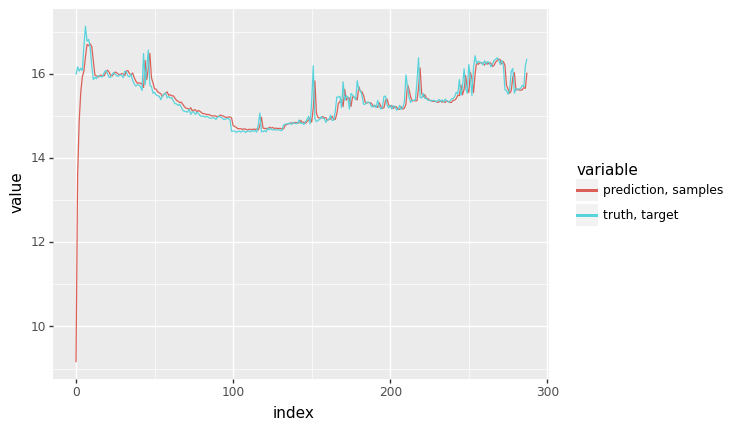

In [201]:
plot = utils.plot_samples(
    embed(val_batch['target'])[2, 1, 0],
    predicted[1, :BLOCK_SIZE],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()